# Data exploration for heriditary connectome data
- ROIs taken from AAL atlas
- Metrics used: surface area, cortical thickness

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [31]:
df = pd.read_csv('SA_AAL_rg.csv')
del df[df.columns[0]]
df.head()

,PreCG_L_SA,SFGdor_L_SA,ORBsup_L_SA,MFG_L_SA,ORBmid_L_SA,IFGoperc_L_SA,IFGtriang_L_SA,ORBinf_L_SA,ROL_L_SA,SMA_L_SA,...,SMG_R_SA,ANG_R_SA,PCUN_R_SA,PCL_R_SA,HES_R_SA,STG_R_SA,TPOsup_R_SA,MTG_R_SA,TPOmid_R_SA,ITG_R_SA
0,1.000000,0.781541,0.599987,0.907600,0.759068,0.890024,0.511923,0.712339,0.682941,0.708343,...,0.463328,0.466748,0.558368,0.661737,1.0,0.616721,0.692335,0.703851,1.000000,0.698570
1,0.784238,1.000000,0.654876,0.889251,0.984121,0.894396,0.481911,0.581138,0.630645,0.885451,...,0.208085,0.485249,0.610696,0.802549,1.0,0.660234,0.583257,0.668746,1.000000,0.534557
2,0.629777,0.687242,1.000000,0.810324,0.999996,0.999981,0.621117,0.891096,0.850146,0.776977,...,0.500591,0.576539,0.880757,0.849701,1.0,0.999999,0.687351,0.660425,1.000000,0.867181
3,0.890097,0.895069,0.799320,1.000000,0.709482,0.863991,0.783207,0.999548,0.600411,0.910495,...,0.721157,0.503557,0.646183,0.847648,1.0,0.593679,0.739358,0.720155,0.999984,0.705786
4,0.832424,0.999978,1.000000,0.716031,1.000000,0.970398,0.000000,1.000000,0.860315,0.999001,...,0.472784,0.987902,0.978636,0.998612,1.0,0.921856,0.746108,0.690314,0.999974,0.999850


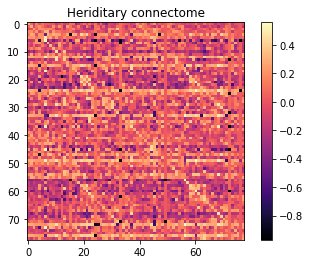

In [38]:
data = df.to_numpy()
plt.imshow(data, cmap='magma')
plt.title('Heriditary connectome')
plt.colorbar()

### PCA

In [33]:
def pca(X):
    
    from scipy.linalg import svd
    X -= np.mean(X,0) # Demean by subtracting column mean
    [U,sigma,V] = svd(X,full_matrices=False) # SVD
    Y = U*sigma
    sigma /= np.sqrt(X.shape[0] - 1)
    evals = np.square(sigma)
    # V are eigenvectors, evals are eigenvalues, Y are projected data
    return V, Y, evals

[evecs,Y,evals] = pca(data)

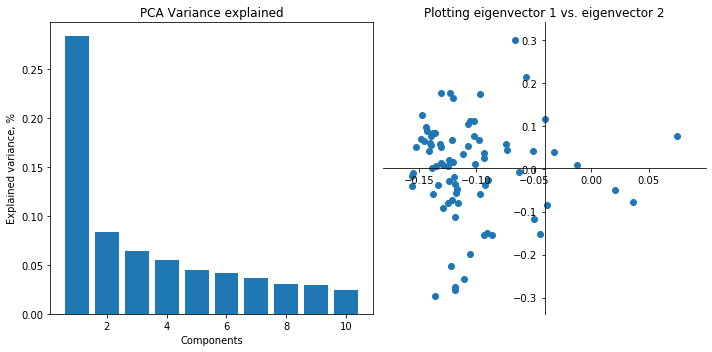

In [34]:
fig = plt.figure(figsize=(10,5))
# Figure 1
total = sum(evals)
var_exp = [(i / total) for i in evals]
cum_var_exp = np.cumsum(var_exp)
# Plot
ax1 = fig.add_subplot(1,2,1)
plt.bar(list(range(1, len(var_exp)+1))[0:10],var_exp[0:10])
plt.title('PCA Variance explained')
plt.xlabel('Components')
plt.ylabel('Explained variance, %')
# Figure 2
eigenvector1 = evecs[0,:]
eigenvector2 = evecs[1,:]
# Plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.spines['left'].set_position('center')
ax2.spines['bottom'].set_position('center')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
plt.scatter(eigenvector1,eigenvector2)
plt.title('Plotting eigenvector 1 vs. eigenvector 2')

plt.tight_layout()

### Laplacian eigenmaps

Text(0.5, 1.0, 'Similarity matrix: eta2')

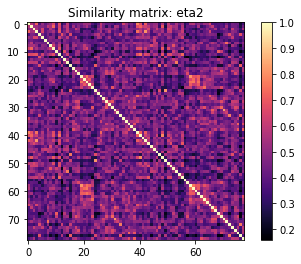

In [35]:
# Construct similarity matrix using eta2
# Can also use other metrics of similarity
def eta2(X):
    
    S = np.zeros((X.shape[0],X.shape[0]))
    for i in range(0,X.shape[0]):
        for j in range(i,X.shape[0]):
            mi = np.mean([X[i,:],X[j,:]],0) 
            mm = np.mean(mi)
            ssw = np.sum(np.square(X[i,:]-mi) + np.square(X[j,:]-mi))
            sst = np.sum(np.square(X[i,:]-mm) + np.square(X[j,:]-mm))
            S[i,j] = 1-ssw/sst
    
    S += S.T 
    S -= np.eye(S.shape[0])
    
    return S

S = eta2(data)

plt.imshow(S,cmap='magma'); plt.colorbar()
plt.title('Similarity matrix: eta2')

Text(0.5, 1.0, 'Symmetric normalized\nGraph Laplacian')

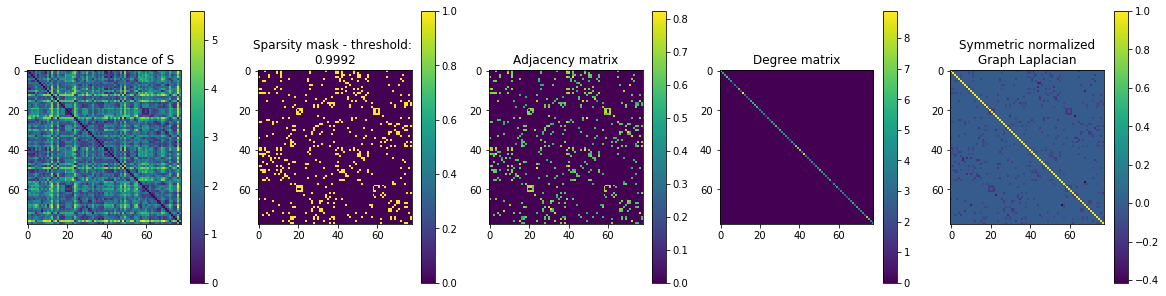

In [36]:
# Generating graph Laplacian
def norm(X):
    
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform

    return squareform(pdist(X))

def adjacency(X):

    from networkx import is_connected
    from networkx import from_numpy_matrix
    
    emin = 0
    emax = np.max(X)
    tol = 0.0001
    maxiter = 1000
    cntr = 0
    
    done = False
    while not done:        
        e = (emin + emax) / 2
        A = (X < e) - np.eye(X.shape[0])
        G = from_numpy_matrix(A)
        if is_connected(G):
            emax = e
            if (emax - emin) < tol:
                done = True
        else:
            emin = e       
        cntr += 1
        if cntr == maxiter:
            done = True      
    
    return A, e

def preprocess_graph(adj,deg):
    
    assert adj.shape == deg.shape
    
    I = np.eye(adj.shape[0])
    deg_ = np.diag(np.power(deg.sum(0),-0.5))
    adj_ = (deg_.dot(adj)).dot(deg_)
    
    return I - adj_

# Compute graph Laplacian using similarity matrix
dist = norm(S)**2
bin_adj, e = adjacency(dist)
adj = np.multiply(bin_adj,S)
deg = np.diag(np.sum(adj,0))
L = preprocess_graph(adj,deg)

fig = plt.figure(figsize=(20,5))
# Figure 1
# Plot
ax1 = fig.add_subplot(1,5,1)
plt.imshow(dist); plt.colorbar()
plt.title('Euclidean distance of S')
# Figure 2
ax2 = fig.add_subplot(1,5,2)
plt.imshow(bin_adj); plt.colorbar()
plt.title('Sparsity mask - threshold: \n' + str(e)[0:6])
# Figure 3
ax3 = fig.add_subplot(1,5,3)
plt.imshow(adj); plt.colorbar()
plt.title('Adjacency matrix')
# Figure 4
ax4 = fig.add_subplot(1,5,4)
plt.imshow(deg); plt.colorbar()
plt.title('Degree matrix')
# Figure 5
ax5 = fig.add_subplot(1,5,5)
plt.imshow(L); plt.colorbar()
plt.title('Symmetric normalized\nGraph Laplacian')

min weight: 0.4802189767044378
max weight: 0.8233826932554558


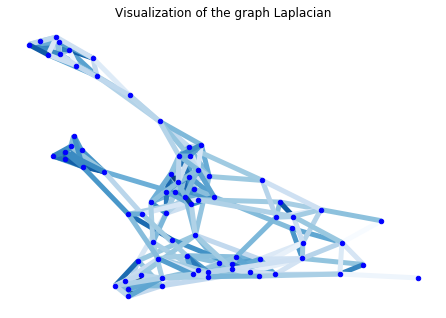

In [37]:
import networkx as nx

G = nx.from_numpy_matrix(adj)
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G)

nx.draw(G,pos, \
        node_color='b', \
        edgelist=edges, \
        edge_color=weights, \
        width=5.0, \
        node_size= 20, \
        edge_cmap=plt.cm.Blues)

plt.title('Visualization of the graph Laplacian')

weights_ = np.asarray(weights)
min_w = weights_.min()
max_w = weights_.max()
print('min weight: ' + str(min_w))
print('max weight: ' + str(max_w))

In [9]:
from scipy.linalg import eigh
eigvals,eigvecs = eigh(L,eigvals=(0,9))

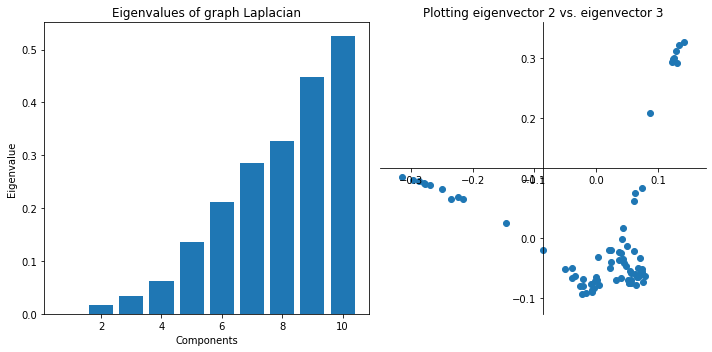

In [10]:
fig = plt.figure(figsize=(10,5))
# Figure 1
# Plot
ax1 = fig.add_subplot(1,2,1)
plt.bar(list(range(1, 11))[0:10],eigvals[0:10])
plt.title('Eigenvalues of graph Laplacian')
plt.xlabel('Components')
plt.ylabel('Eigenvalue')
# Figure 2
eigenvector1 = eigvecs[:,1]
eigenvector2 = eigvecs[:,2]
# Plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.spines['left'].set_position('center')
ax2.spines['bottom'].set_position('center')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
plt.scatter(eigenvector1,eigenvector2)
plt.title('Plotting eigenvector 2 vs. eigenvector 3')

plt.tight_layout()